In [ ]:
#### Homework Assignment 1: Adversarial Examples

## This jupyter notebook aims to get familiar with the untargted and targeted methods for generating adversarial examples
## We will try to attack a pretrained ImageNet ResNet50 model on a given ImageNet image .

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

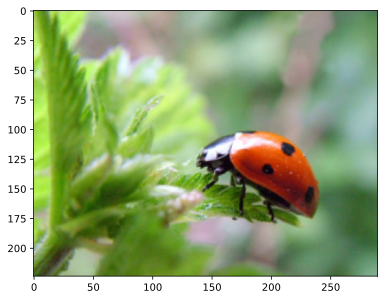

In [ ]:
## Load the sample ImageNet image (which is an image of ladybug) and visualize it

from PIL import Image
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
ladybug_img = Image.open("ladybug.jpg")

preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
ladybug_tensor = preprocess(ladybug_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(ladybug_tensor[0].numpy().transpose(1,2,0))

In [ ]:
## Prepare the ImageNet ResNet50 classification model
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode
model = resnet50(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}

# form the prediction on the clean ladybug image
pred_ladybug = model(norm(ladybug_tensor))
print(imagenet_classes[pred_ladybug.max(dim=1)[1].item()])

ladybug


In [ ]:
# 301 is the class index corresponding to the ImageNet class "ladybug"
# form the cross-entropy loss on the prediction according to the ground truth label
print(nn.CrossEntropyLoss()(model(norm(ladybug_tensor)),torch.LongTensor([301])).item())

0.07101953774690628


In [ ]:
ladybug_tensor_cp = ladybug_tensor.clone().detach()

In [ ]:
## Your task 1: implement the simple version of untargeted PGD attack - make necessary changes to the following code
import torch.optim as optim
epsilon = 2./255
ladybug_tensor.requires_grad_()
# delta stores the generated perturbation and updates its value iteratively
delta = torch.zeros([1, 3, 224, 290])
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([ladybug_tensor], lr=0.1)
for t in range(30):
    pred = model(norm(ladybug_tensor + delta))
    print(imagenet_classes[pred.max(dim=1)[1].item()])
    loss =  nn.CrossEntropyLoss()(pred,torch.LongTensor([301])).item()

    output = criterion(pred, torch.LongTensor([301]))

    # Backward pass to compute the gradient
    output.backward()

    # Clip the gradient to the range [-epsilon, epsilon]
    torch.nn.utils.clip_grad_value_(ladybug_tensor, epsilon)
    original_gradient = ladybug_tensor.grad

    # Access the gradient of x
    delta+= 0.1*original_gradient

    with torch.no_grad():
        ladybug_tensor_cp += 0.1 * original_gradient
        ladybug_tensor.grad.zero_()


    if t % 5 == 0:
        print(t, loss)

# pred stores the model predicted logits of the generated adversarial example
print("True class probability:", nn.Softmax(dim=1)(pred)[0,301].item())

ladybug
0 0.07101953774690628
ladybug
ladybug
leaf_beetle
leaf_beetle
leaf_beetle
5 6.011438846588135
leaf_beetle
leaf_beetle
leaf_beetle
leaf_beetle
leaf_beetle
10 16.163524627685547
leaf_beetle
leaf_beetle
leaf_beetle
leaf_beetle
leaf_beetle
15 24.101951599121094
leaf_beetle
leaf_beetle
leaf_beetle
leaf_beetle
leaf_beetle
20 30.71928596496582
leaf_beetle
leaf_beetle
leaf_beetle
leaf_beetle
leaf_beetle
25 36.147216796875
leaf_beetle
leaf_beetle
leaf_beetle
leaf_beetle
True class probability: 3.399174443399631e-18


In [ ]:
ladybug_tensor

In [ ]:
## check the predicted class of the generated adversarial example and its prediction probability
pred = model(norm(ladybug_tensor_cp))
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  leaf_beetle
Predicted probability: 0.9971291422843933


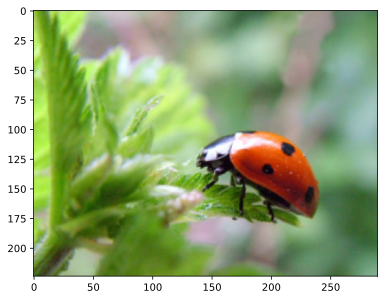

In [ ]:
# plot the original ladybug image
plt.imshow(ladybug_tensor[0].detach().numpy().transpose(1,2,0))

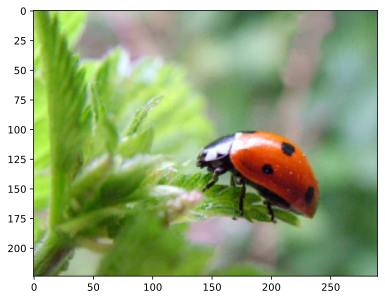

In [ ]:
# plot the adversarially perturbed ladybug image
plt.imshow((ladybug_tensor_cp)[0].detach().numpy().transpose(1,2,0))

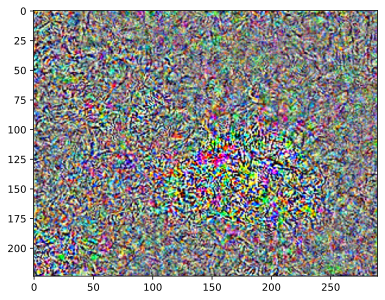

In [ ]:
# plot the generated adversarial perturbation
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

In [ ]:
## Your task 2: implement the basic version of targeted attack - make necessary changes to the following code
## Targeted label: zebra; Class index: 340


delta = torch.zeros([1, 3, 224, 290])
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([ladybug_tensor], lr=0.1)
ladybug_tensor.requires_grad_()
for t in range(100):
    pred = model(norm(ladybug_tensor + delta))
    print(imagenet_classes[pred.max(dim=1)[1].item()])
    #loss =  nn.CrossEntropyLoss()(pred,torch.LongTensor([301])).item()
    loss1 =  nn.CrossEntropyLoss()(pred,torch.LongTensor([340])).item()

    #output = criterion(pred, torch.LongTensor([301]))
    output1 = criterion(pred, torch.LongTensor([340]))

    # Backward pass to compute the gradient
    output1.backward()

    # Clip the gradient to the range [-epsilon, epsilon]
    torch.nn.utils.clip_grad_value_(ladybug_tensor, epsilon)
    original_gradient = ladybug_tensor.grad

    # Access the gradient of x
    delta -= 0.005*original_gradient

    with torch.no_grad():
        ladybug_tensor_cp -= 0.005 * original_gradient
        ladybug_tensor.grad.zero_()


    if t % 10 == 0:
        print(t, loss1)

# pred stores the model predicted logits of the generated adversarial example
print("True class probability:", nn.Softmax(dim=1)(pred)[0,301].item())

ladybug
0 19.54693031311035
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
10 16.137529373168945
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
20 13.292744636535645
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
30 10.9442720413208
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
40 8.95203685760498
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
50 7.319040298461914
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
60 5.926813125610352
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
70 4.706644535064697
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
80 3.4366531372070312
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
ladybug
zebra
90 2.195094108581543
zebra
zebra
zebra
zebra
zebra
zebra
zebra
zebra
zebra
True class

In [ ]:
## check the predicted class of the generated adversarial example and its prediction probability
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  zebra
Predicted probability: 0.3069319427013397


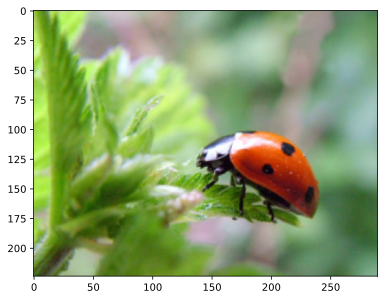

In [ ]:
# plot the original ladybug image
plt.imshow(ladybug_tensor[0].detach().numpy().transpose(1,2,0))

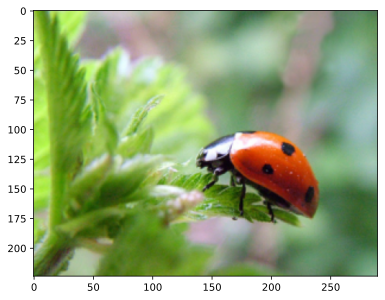

In [ ]:
# plot the adversarially perturbed ladybug image
plt.imshow((ladybug_tensor + delta)[0].detach().numpy().transpose(1,2,0))

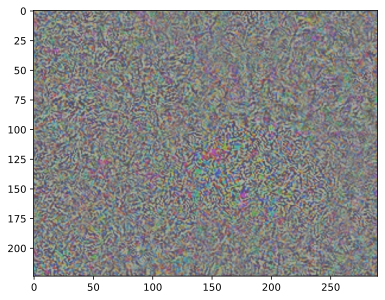

In [ ]:
# plot the generated adversasrial perturbation
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))